## Project 2

In [6]:
### Module imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sqlalchemy import create_engine
import shapefile

## import of the 2 functions geocoding: adress_coord and best journey: best_journey
from location import adress_coord
from locations import pd_adress_coord
from best_journey import best_journey

### 1. Open the data 

In [2]:
students_list = pd.read_csv('students.csv')
schools_list = pd.read_csv('schools.csv')

## To test the requests on table student
test_students = pd.read_csv('test_students.csv')

schools_list.head()

,school_name,school_address
0,ANTOINE COYSEVOX,"16 Rue Coysevox, 75018 Paris"
1,HECTOR BERLIOZ,"17 Rue Georgette Agutte, 75018 Paris"
2,GERARD PHILIPE,"8 Rue des Amiraux, 75018 Paris"
3,MARIE CURIE,"21 Rue Boinod, 75018 Paris"
4,EDOUARD PAILLERON,"33 Rue Edouard Pailleron, 75019 Paris"


## By using openrouteservice API
- we create and test a function to geolocate
- we create a function to have the best journey between two locations

In [3]:
### Geocoding URL 
url_geocoding = 'https://api.openrouteservice.org/geocode/search?api_key=5b3ce3597851110001cf624894bc9991e18844d58c8215f966965e3d&text=5 avenue Anatole France, 75007 Paris'


## Header Dictionnary 
header_dict = {
    "Authorization" : '5b3ce3597851110001cf624894bc9991e18844d58c8215f966965e3d'
}

## best_journey URL 
post_url = 'https://api.openrouteservice.org/v2/' + 'directions/' + 'foot-walking/' + 'json'

In [7]:
## Test requests of the 2 functions 

## geocoding an adress 
test_1 = adress_coord(url_geocoding, header_dict)

## find the best journey between two locations
a = best_journey(post_url,(2.36309,48.86703),(2.32738,48.86381),header_dict["Authorization"], 'name',False)

## Calculate data

In [4]:
## ------------- 3.1--------------------------####
## Generating school_location.csv

pd_adress_coord(schools_list,header_dict["Authorization" ],'schools_location')

In [5]:
## ------------- 3.2--------------------------####
### Create, for each student, a JSON file (journey_<student_id>.json) 
## with the best journey between his home and his school (put them in a subfolder journeys)

for i in range (test_students.shape[0]):
    
    authentification = header_dict["Authorization"]
    start = (students_list.loc[i][4], students_list.loc[i][3])
    geocoding_url= 'https://api.openrouteservice.org/geocode/search?api_key='+ authentification+'&text='+schools_list.loc[schools_list['school_name'] == students_list.loc[i][2]].school_address[0]
    
    end = (adress_coord(geocoding_url,header_dict)[0],adress_coord(geocoding_url,header_dict)[1])
    
    name = str(students_list.loc[i][0])
    post_url = 'https://api.openrouteservice.org/v2/' + 'directions/' + 'foot-walking/' + 'json'
    
    best_journey(post_url, start,end,authentification,name, json_file=True)

## 4. create a students_stat.csv file with the duration (in seconds) of the journey of each student between his home and his school

In [24]:
### Append a new columns on the file test_students
durations = []

for i in range (test_students.shape[0]):
    
    authentification = header_dict["Authorization"]
    start = (test_students.loc[i][4], test_students.loc[i][3])    
    
    geocoding_url= 'https://api.openrouteservice.org/geocode/search?api_key='+ authentification+'&text='+schools_list.loc[schools_list['school_name'] == students_list.loc[i][2]].school_address[0]
    
    end = (adress_coord(geocoding_url,header_dict)[0],adress_coord(geocoding_url,header_dict)[1])

    post_url = 'https://api.openrouteservice.org/v2/' + 'directions/' + 'foot-walking/' + 'json'
    
    
    distance, duration = best_journey(post_url, start,end,authentification,'name', False)
    
    durations.append(duration)
    #print(i , duration)

test_students['duration'] = durations

## Make statistics

<AxesSubplot:xlabel='id'>

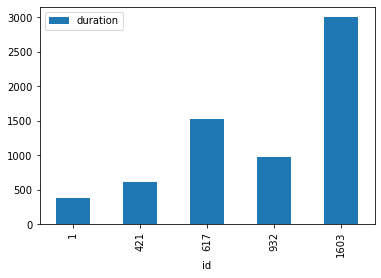

In [14]:
####---------4.2-------------------------##
## A global Bar chart of the duration 

test_students.plot(x = 'id', y = 'duration', kind = 'bar')

<AxesSubplot:xlabel='school_name'>

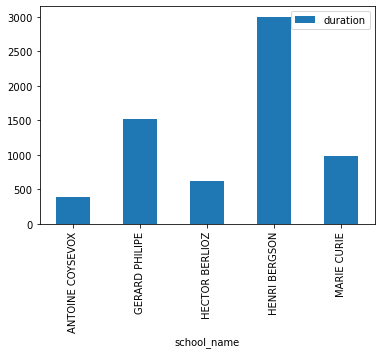

In [25]:
####---------4.3-------------------------##
## A global Bar chart of the duration for each 
duration_school = test_students['duration'].groupby(by = test_students['school_name']).sum()
duration_school.plot(x = test_students['school_name'] ,kind = 'bar', legend = True)

## Make Shapefile data: (optional)

In [26]:
schools_location = pd.read_csv('schools_location.csv')

In [21]:
## Creation of a function to create a geometry point and write it in a shapefile 

def create_shp(data, fields, geometry_fields,output):
    with shapefile.Writer(output) as w:
    
    ### creation of the needs fields
        for i in range (len(fields)):
            w.field(fields[i], 'C')

        ### recording of the element
        for i in range(data.shape[0]):
            ## record_raw will save all the values of each lenght 
            #and then will be use to split to be record 
            
            record_raw = str()
            for j in range (len(fields)):
                if record_raw == '':
                    record_raw = str(data[fields[j]].loc[i])
                else : 
                    record_raw = record_raw + ':' + str(data[fields[j]].loc[i])
                
            ## Recording of the fields
            w.record(*record_raw.split(':'))
            
            ## Recording of the geometry fields 
            w.point(data[geometry_fields[0]].loc[i],data[geometry_fields[1]].loc[i])
            
    return output

In [22]:
### Creation of students files 
create_shp(students_list, ['id','student_address', 'school_name'],
           ['student_longitude', 'student_latitude'], 'shapefiles/students')

'shapefiles/students'

In [23]:
### Creation of school files 
create_shp(schools_location, ['school_address'],
           ['latitude', 'longitude'], 'shapefiles/schools')

'shapefiles/schools'